In [71]:
  df <- read.table("sstoi.indices.txt", header=T)
  df$time <- df$YR + (df$MON - .5) / 12
  df$simple <- df$NINO3.4 - mean(df$NINO3.4)
  df$status <- ifelse(df$simple > .5, 'El Nino',
               ifelse(df$simple < -.5, 'La Nina', 'Neutral'))

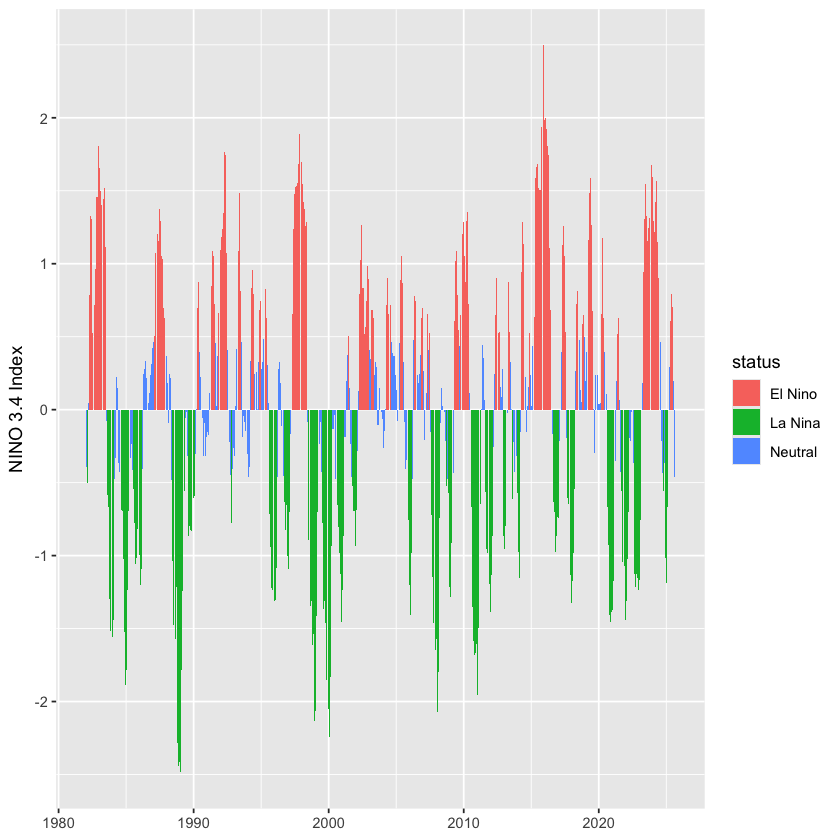

In [72]:
library(ggplot2)

ggplot(df, aes(time, simple, fill=status)) +
    geom_col() + xlab(NULL) + ylab('NINO 3.4 Index')

In [73]:
df$Lsimple = c(NA, df$simple[1:(nrow(df)-1)])

In [74]:
summary(lm(simple ~ Lsimple, data=df))


Call:
lm(formula = simple ~ Lsimple, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25869 -0.26403 -0.01158  0.24174  1.08669 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.698e-05  1.693e-02  -0.003    0.997    
Lsimple      9.135e-01  1.784e-02  51.216   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3872 on 521 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8343,	Adjusted R-squared:  0.834 
F-statistic:  2623 on 1 and 521 DF,  p-value: < 2.2e-16


In [76]:
mod = lm(simple ~ Lsimple, data=df)

In [77]:
df$yhat = predict(mod, df)

Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


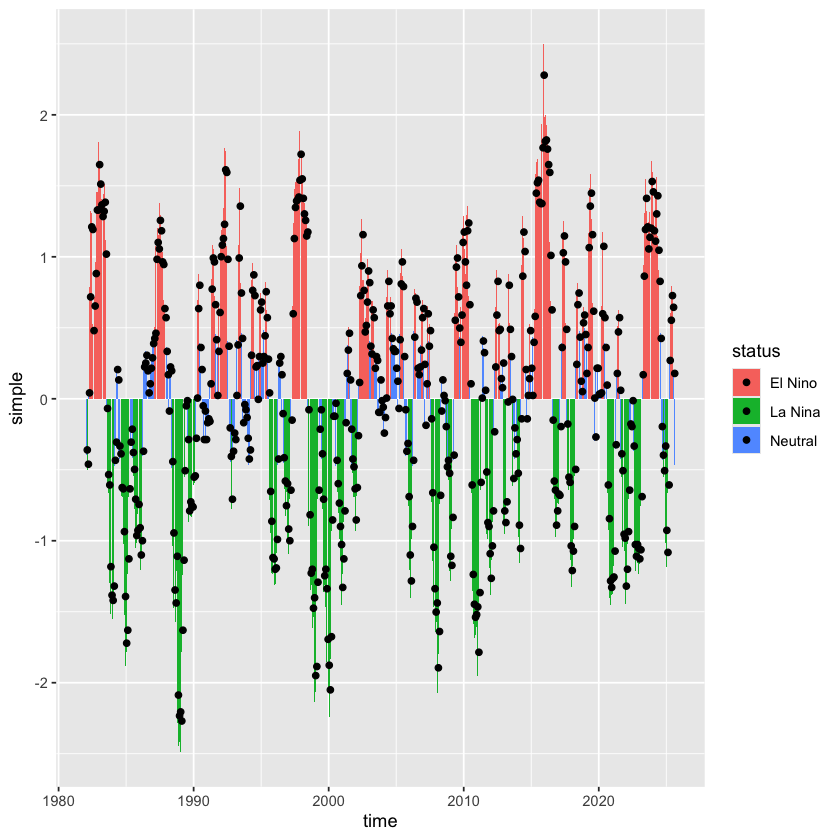

In [38]:
library(ggplot2)

ggplot(df, aes(time, simple, fill=status)) +
    geom_col() + geom_point(aes(y=yhat))

Let's do some machine learning to build as good of a lag-based model as possible.

In [78]:
make.lags = function(df, var, count) {
    lagvar = paste0("L", var)
    df[, lagvar] = c(NA, df[1:(nrow(df)-1), var])
    if (count == 1)
        return(df)
    return(make.lags(df, lagvar, count-1))
}

In [79]:
df2 = make.lags(df, 'simple', 3)

In [80]:
head(df2)

,YR,MON,NINO1.2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3,time,simple,status,Lsimple,yhat,LLsimple,LLLsimple
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,1982.042,-0.39450382,Neutral,NA,NA,NA,NA
2,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,1982.125,-0.50450382,La Nina,-0.39450382,-0.36041825,NA,NA
3,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,1982.208,0.04549618,Neutral,-0.50450382,-0.46089824,-0.39450382,NA
4,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,1982.292,0.78549618,El Nino,0.04549618,0.04150171,-0.50450382,-0.39450382
5,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,1982.375,1.32549618,El Nino,0.78549618,0.71745801,0.04549618,-0.50450382
6,1982,6,22.88,-0.29,27.10,0.46,29.46,0.62,28.35,0.65,1982.458,1.30549618,El Nino,1.32549618,1.21072342,0.78549618,0.04549618


In [82]:
mod = lm(simple ~ Lsimple + LLsimple + LLLsimple, data=df2)

In [83]:
summary(mod)


Call:
lm(formula = simple ~ Lsimple + LLsimple + LLLsimple, data = df2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.43070 -0.19634  0.00832  0.20171  0.94214 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.001339   0.014200  -0.094    0.925    
Lsimple      1.429662   0.043898  32.568  < 2e-16 ***
LLsimple    -0.584070   0.072146  -8.096 4.11e-15 ***
LLLsimple    0.024248   0.043966   0.552    0.582    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3241 on 517 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.8847,	Adjusted R-squared:  0.8841 
F-statistic:  1323 on 3 and 517 DF,  p-value: < 2.2e-16


Our cross-validation question is, what model can best predict the next month?

In [86]:
make.formula.helper = function(var, count) {
    if (count == 1)
        return(paste0("L", var))
    return(paste0("L", c(var, make.formula.helper(var, count-1))))
}
make.formula = function(var, count) {
    as.formula(paste(var, "~", paste(make.formula.helper(var, count), collapse=" + ")))
}

In [87]:
summary(lm(make.formula('simple', 3), make.lags(df, 'simple', 3)))


Call:
lm(formula = make.formula("simple", 3), data = make.lags(df, 
    "simple", 3))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.43070 -0.19634  0.00832  0.20171  0.94214 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.001339   0.014200  -0.094    0.925    
Lsimple      1.429662   0.043898  32.568  < 2e-16 ***
LLsimple    -0.584070   0.072146  -8.096 4.11e-15 ***
LLLsimple    0.024248   0.043966   0.552    0.582    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3241 on 517 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.8847,	Adjusted R-squared:  0.8841 
F-statistic:  1323 on 3 and 517 DF,  p-value: < 2.2e-16


In [94]:
results = data.frame()
for (count in 1:20) {
    mod = lm(make.formula('simple', count), make.lags(df, 'simple', count))
    results = rbind(results, data.frame(count, mse=mean(resid(mod)^2)))
}

In [89]:
results

count,mse
<int>,<dbl>
1,0.14935338
2,0.10466703
3,0.10423887
4,0.10342531
5,0.10344288
6,0.09981212
7,0.09902166
8,0.09615386
9,0.09416671


Leave-one-out cross-validation

In [97]:
results$loo = NA
for (count in 1:20) {
    df2 = make.lags(df, 'simple', count)
    form = make.formula('simple', count)
    resids = c()
    for (ii in 1:nrow(df)) {
        mod = lm(form, df2[-ii,])
        residii = predict(mod, df2[ii,]) - df2$simple[ii]
        resids = c(resids, residii)
    }
    results$loo[count] = mean(resids^2, na.rm=T)
}

In [98]:
results

count,mse,loo
<int>,<dbl>,<dbl>
1,0.14935338,0.15043531
2,0.10466703,0.10582942
3,0.10423887,0.10572379
4,0.10342531,0.10532218
5,0.10344288,0.10573270
6,0.09981212,0.10242150
7,0.09902166,0.10201414
8,0.09615386,0.09956405
9,0.09416671,0.09793480


In [101]:
df$fold = rep(1:10, each=ceiling(nrow(df) / 10))[1:nrow(df)]

In [102]:
results$tenfold = NA
for (count in 1:20) {
    df2 = make.lags(df, 'simple', count)
    form = make.formula('simple', count)
    resids = c()
    for (fold in 1:10) {
        mod = lm(form, df2[df2$fold != fold,])
        residii = predict(mod, df2[df2$fold == fold,]) - df2$simple[df2$fold == fold]
        resids = c(resids, residii)
    }
    results$tenfold[count] = mean(resids^2, na.rm=T)
}

In [103]:
results

count,mse,loo,tenfold
<int>,<dbl>,<dbl>,<dbl>
1,0.14935338,0.15043531,0.14965634
2,0.10466703,0.10582942,0.10547241
3,0.10423887,0.10572379,0.10515122
4,0.10342531,0.10532218,0.10448583
5,0.10344288,0.10573270,0.10489293
6,0.09981212,0.10242150,0.10228535
7,0.09902166,0.10201414,0.10189090
8,0.09615386,0.09956405,0.09929068
9,0.09416671,0.09793480,0.09772134


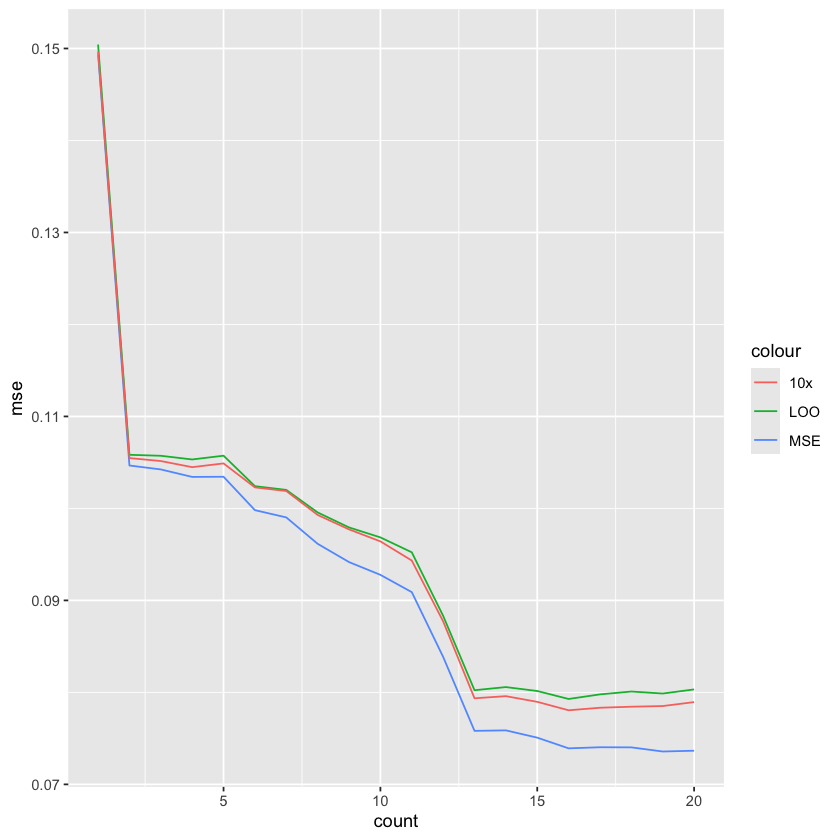

In [106]:
ggplot(results, aes(count)) +
geom_line(aes(y=mse, colour='MSE')) + 
geom_line(aes(y=loo, colour='LOO')) + 
geom_line(aes(y=tenfold, colour='10x'))

Iterative projection

In [107]:
df2 = df[, c('time', 'simple', 'Lsimple')]
mod = lm(simple ~ Lsimple, data=df)
for (ii in 1:24) {
    lastrow = tail(df2, 1)
    simple = predict(mod, data.frame(Lsimple=lastrow$simple))
    df2 = rbind(df2, data.frame(time=lastrow$time + 1/12, simple, Lsimple=lastrow$simple))
}

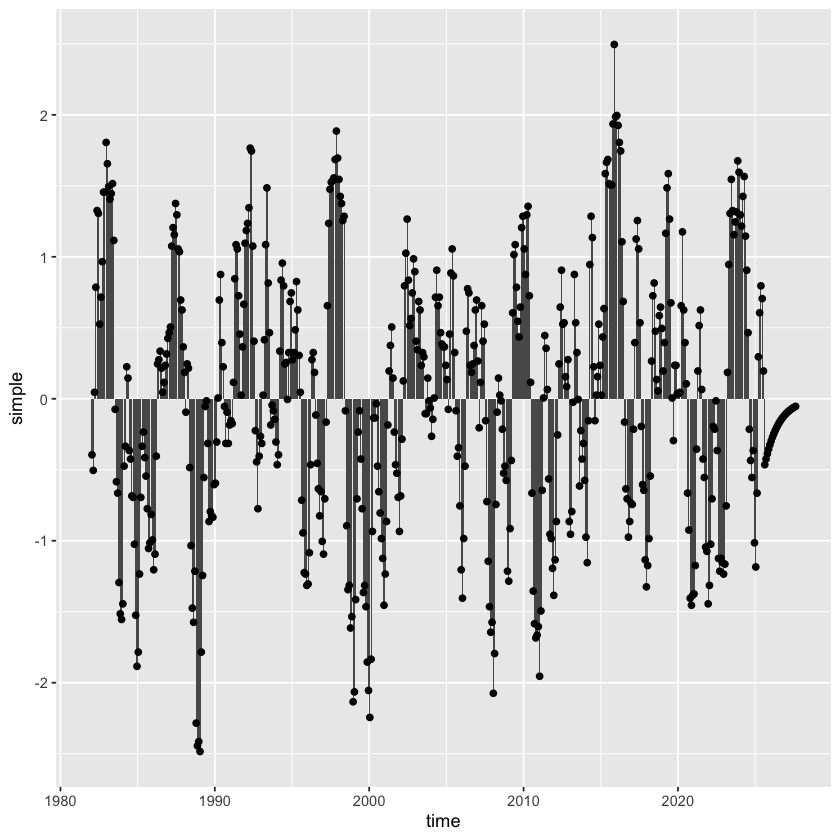

In [108]:
ggplot(df, aes(time, simple)) +
    geom_col() + geom_point(data=df2, aes(y=simple))

In [114]:
df2 = make.lags(df, 'simple', 2)[, c('time', 'simple', 'Lsimple', 'LLsimple')]
mod = lm(simple ~ Lsimple + LLsimple, data=df2)
for (ii in 1:24) {
    lastrow = tail(df2, 1)
    nextrow = data.frame(time=lastrow$time + 1/12, Lsimple=lastrow$simple, LLsimple=lastrow$Lsimple)
    nextrow$simple = predict(mod, nextrow)
    df2 = rbind(df2, nextrow)
}

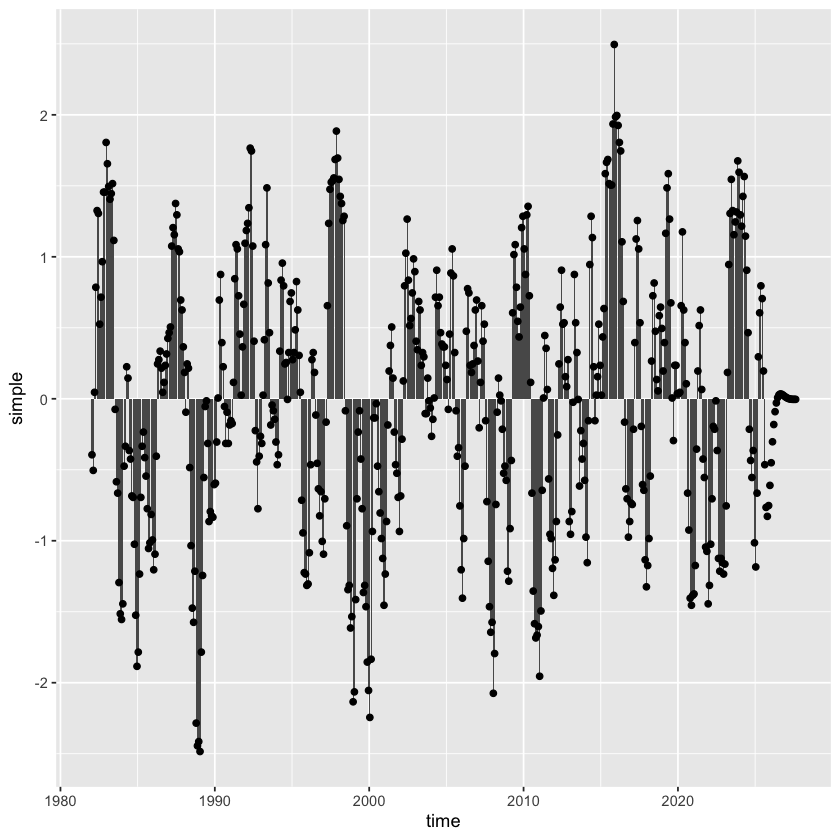

In [115]:
ggplot(df, aes(time, simple)) +
    geom_col() + geom_point(data=df2, aes(y=simple))

In [117]:
project = function(df2, count, mod, len) {
    for (ii in 1:len) {
        df2 = rbind(df2, tail(df2, 1))
        df2 = make.lags(df2, 'simple', count)
        df2$time[nrow(df2)] = lastrow$time[nrow(df2)] + 1/12
        df2$simple[nrow(df2)] = predict(mod, df2[nrow(df2),])
    }
    df2
}

In [ ]:
results$tenfold2 = NA
for (count in 1:20) {
    df2 = make.lags(df, 'simple', count)
    form = make.formula('simple', count)
    resids = c()
    for (fold in 2:10) {
        mod = lm(form, df2[df2$fold != fold,])
        df3 = project(df2[df2$fold < fold,], count, mod, sum(df2$fold == fold))
        residii = df3$simple[df2$fold == fold] - df2$simple[df2$fold == fold]
        resids = c(resids, residii)
    }
    results$tenfold2[count] = mean(resids^2, na.rm=T)
}